<a href="https://colab.research.google.com/github/egorbolychev/Algopack-Deploy/blob/main/ml/models/sber_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

In [2]:
PATH_TO_DATA= '/content/drive/MyDrive/Colab Notebooks/goalgo_hac/data/'
df = pd.read_csv(PATH_TO_DATA+'sber_tradestats.csv')

# **Подготовка данных для нейронной сети**

In [3]:
df = df.drop(['Unnamed: 0'],axis=1)
df

,pr_open,pr_high,pr_low,pr_close,pr_std,vol,val,trades,pr_vwap,pr_change,trades_b,trades_s,val_b,val_s,vol_b,vol_s,disb,pr_vwap_b,pr_vwap_s,target
0,255.97,256.97,255.85,256.77,0.0001,116141.0,297831085.0,1935.0,256.44,0.3125,1091.0,844.0,171039244.0,126791841.0,66691.0,49450.0,0.15,256.47,256.40,0.00
1,256.20,256.32,256.09,256.22,0.0001,13225.0,33879268.0,257.0,256.18,0.0078,120.0,137.0,12972945.0,20906323.0,5063.0,8162.0,-0.23,256.23,256.14,0.00
2,255.78,256.34,255.52,256.26,0.0001,48369.0,123767265.0,777.0,255.88,0.1877,439.0,338.0,73966037.0,49801228.0,28900.0,19469.0,0.19,255.94,255.80,0.00
3,256.64,256.74,256.27,256.50,0.0001,25798.0,66180111.0,440.0,256.53,-0.0546,186.0,254.0,25693661.0,40486449.0,10014.0,15784.0,-0.22,256.58,256.50,0.00
4,257.00,257.10,256.77,256.90,0.0001,25299.0,65007573.0,359.0,256.96,-0.0389,222.0,137.0,30354637.0,34652935.0,11813.0,13486.0,-0.07,256.96,256.95,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16709,268.53,268.80,268.50,268.70,0.0000,25773.0,69252793.0,408.0,268.70,0.0633,278.0,130.0,43109719.0,26143073.0,16043.0,9730.0,0.24,268.71,268.69,-0.36
16710,268.68,268.74,268.51,268.55,0.0000,4894.0,13146346.0,177.0,268.62,-0.0484,87.0,90.0,6758057.0,6388289.0,2516.0,2378.0,0.03,268.60,268.64,-0.45
16711,268.23,268.24,267.55,267.75,0.0000,31559.0,84526934.0,1012.0,267.84,-0.1790,196.0,816.0,16311124.0,68215810.0,6092.0,25467.0,-0.61,267.75,267.86,-0.27
16712,268.34,268.44,268.32,268.44,0.0000,33087.0,88792822.0,484.0,268.36,0.0373,394.0,90.0,83221809.0,5571012.0,31011.0,2076.0,0.87,268.36,268.35,-0.39


In [4]:
df['target'].describe()

count    16714.000000
mean        -0.031621
std          1.908545
min        -54.960000
25%         -0.690000
50%         -0.040000
75%          0.640000
max         19.610000
Name: target, dtype: float64

In [5]:
df_numpy = df.to_numpy()
df_numpy

array([[255.97, 256.97, 255.85, ..., 256.47, 256.4 ,   0.  ],
       [256.2 , 256.32, 256.09, ..., 256.23, 256.14,   0.  ],
       [255.78, 256.34, 255.52, ..., 255.94, 255.8 ,   0.  ],
       ...,
       [268.23, 268.24, 267.55, ..., 267.75, 267.86,  -0.27],
       [268.34, 268.44, 268.32, ..., 268.36, 268.35,  -0.39],
       [268.77, 268.79, 268.74, ..., 268.79, 268.77,  -0.4 ]])

In [6]:
from sklearn.preprocessing import MinMaxScaler
feature_sc = MinMaxScaler(feature_range=(-1,1))
df_numpy_scaled = feature_sc.fit_transform(df_numpy)

# **Разбивка данных на прзинаки и таргет, преобразование для работы с временными рядами**

In [7]:
X = []
windows = 10
cols = df_numpy_scaled.shape[1]

for j in range(cols):
  X.append([])
  for i in range(windows, df_numpy_scaled.shape[0]):
    X[j].append(df_numpy_scaled[i-windows:i, j])

X=np.moveaxis(X, [0], [2])
X, yi =np.array(X), np.array(df_numpy_scaled[windows:,-1])
y=np.reshape(yi,(len(yi),1))

print(X.shape)
print(y.shape)

(16704, 10, 20)
(16704, 1)


In [8]:
splitlimit = int(X.shape[0]*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

13363


((13363, 10, 20), (3341, 10, 20), (13363, 1), (3341, 1))

In [9]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([13363, 10, 20]),
 torch.Size([3341, 10, 20]),
 torch.Size([13363, 1]),
 torch.Size([3341, 1]))

# **Создание класса для работы с нейронкой, написанной на pytorch**

In [10]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [11]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [12]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# **Потсроение модели прогнозирования изменения акций (LSTM)**

In [13]:
class ChangeModel(nn.Module):
  def __init__(self,input_size, hidden_size,num_stacked_size):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_stacked_size = num_stacked_size
    self.lstm = nn.LSTM(input_size,hidden_size,num_stacked_size,batch_first=True)
    self.lin = nn.Linear(hidden_size,1)
  def forward(self,x):
    batch = x.size(0)
    h0 = torch.zeros(self.num_stacked_size,batch,self.hidden_size).to(device)
    c0 = torch.zeros(self.num_stacked_size,batch,self.hidden_size).to(device)
    out,_ =self.lstm(x,(h0,c0))
    out = self.lin(out[:,-1,:])
    return out

# **Тренировка модели + отладка на валидационной выборке**

In [14]:
model = ChangeModel(20,20,1)
model.to(device)
epochs = 30
loss_function = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(),lr = 0.01)
for epoch in range(epochs):
   model.train(True)
   print(f'Epoch: {epoch + 1}')
   running_loss = 0.0

   for batch_index, batch in enumerate(train_loader):
      x_batch, y_batch = batch[0].to(device), batch[1].to(device)

      output = model(x_batch)
      loss = loss_function(output, y_batch)
      running_loss += loss.item()

      optim.zero_grad()
      loss.backward()
      optim.step()

      if batch_index % 100 == 99:  # print every 100 batches
          avg_loss_across_batches = running_loss / 100
          print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                  avg_loss_across_batches))
      running_loss = 0.0
   print()

   model.train(False)
   running_loss = 0.0

   for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

   avg_loss_across_batches = running_loss / len(test_loader)

   print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
   print('***************************************************')
   print()


Epoch: 1
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 2
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 3
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.000
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000
Batch 400, Loss: 0.000
Batch 500, Loss: 0.000
Batch 600, Loss: 0.000
Batch 700, Loss: 0.000
Batch 800, Loss: 0.000

Val Loss: 0.000
*

# **Результат модели на тренировочной выборке**

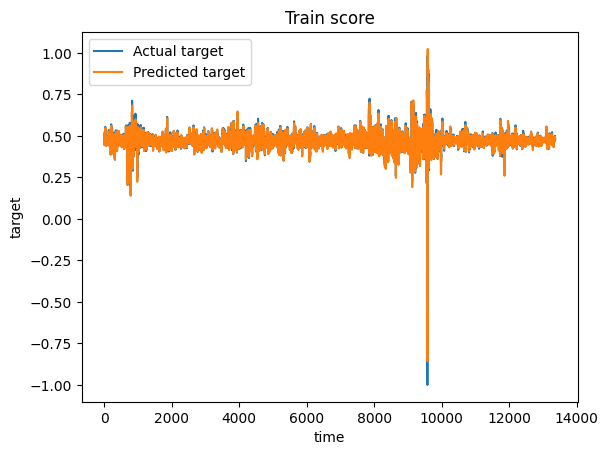

In [15]:
from matplotlib import pyplot as plt
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.title('Train score')
plt.plot(y_train, label='Actual target')
plt.plot(predicted, label='Predicted target')
plt.xlabel('time')
plt.ylabel('target')
plt.legend()
plt.show()


# **Результат модели на валидационной выборке**

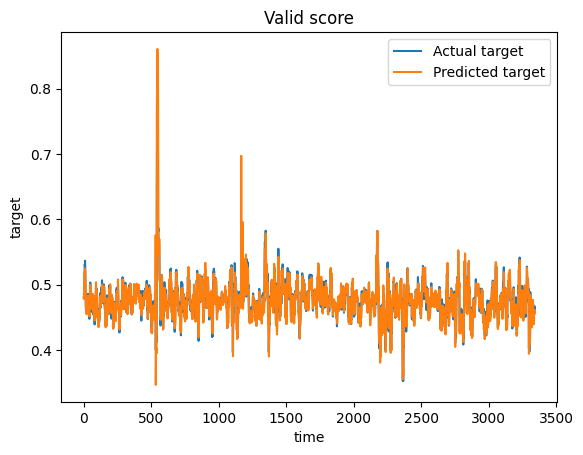

In [16]:
from matplotlib import pyplot as plt
with torch.no_grad():
    predicted = model(X_test.to(device)).to('cpu').numpy()

plt.title('Valid score')
plt.plot(y_test, label='Actual target')
plt.plot(predicted, label='Predicted target')
plt.xlabel('time')
plt.ylabel('target')
plt.legend()
plt.show()

# **Сохранение модели и проверка корректности ее закгрузки**

In [17]:
PATH_TO_MODEL = '/content/drive/MyDrive/Colab Notebooks/goalgo_hac/models/'
torch.save(model,PATH_TO_MODEL+'sber_model.pt')

In [18]:
test_model = ChangeModel(20,20,1)
test_model = torch.load(PATH_TO_MODEL+'sber_model.pt')
test_model.eval()

ChangeModel(
  (lstm): LSTM(20, 20, batch_first=True)
  (lin): Linear(in_features=20, out_features=1, bias=True)
)